# Extracting meteorological data for counties in USA - Precipitation data

## Setup

In [2]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd

import os
import sys
import glob

import shape_utils as shape

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [3]:
folders = glob.glob('/data/misc/covid-19/data_nc_daily/precip*')
filepaths = []
for folder in folders:
    filepaths.extend(glob.glob(os.path.join(folder, '*.nc')))
print(len(filepaths))

182


In [4]:
%%time
cubes = iris.load(filepaths)
    
print(cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 1920; longitude: 2560)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 1920; longitude: 2560)
CPU times: user 12.2 s, sys: 636 ms, total: 12.8 s
Wall time: 1min 48s


In [5]:
us_latlon = ((18, 75), (-179, -65))
us_cubes = iris.cube.CubeList([cube.intersection(latitude=us_latlon[0], longitude=us_latlon[1]) for cube in cubes])
print(us_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)


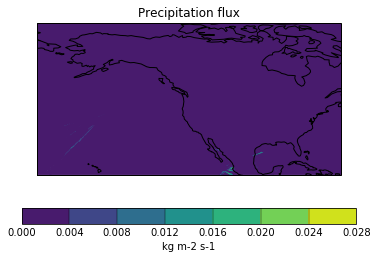

In [6]:
qplt.contourf(us_cubes[0][0])
plt.gca().coastlines()

In [7]:
CRS = us_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

### Load shapefile

In [8]:
regions_shp = '/data/misc/covid-19/shapefiles/USA/US_COUNTY_POP.shx'
regions_reader = shpreader.Reader(regions_shp)

In [9]:
len([record for record in regions_reader.records()])

3142

In [10]:
next(regions_reader.records())

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f33ae92e198>, {'OBJECTID': 1, 'NAME': 'Autauga', 'STATE_NAME': 'Alabama', 'STATE_FIPS': '01', 'CNTY_FIPS': '001', 'FIPS': '01001', 'POPULATION': 56903, 'POP_SQMI': 94.2, 'POP2010': 54571, 'POP10_SQMI': 90.3, 'WHITE': 42855, 'BLACK': 9643, 'AMERI_ES': 232, 'ASIAN': 474, 'HAWN_PI': 32, 'HISPANIC': 1310, 'OTHER': 466, 'MULT_RACE': 869, 'MALES': 26569, 'FEMALES': 28002, 'AGE_UNDER5': 3579, 'AGE_5_9': 3991, 'AGE_10_14': 4290, 'AGE_15_19': 4290, 'AGE_20_24': 3080, 'AGE_25_34': 6487, 'AGE_35_44': 8243, 'AGE_45_54': 8205, 'AGE_55_64': 5860, 'AGE_65_74': 4013, 'AGE_75_84': 1982, 'AGE_85_UP': 551, 'MED_AGE': 36.9, 'MED_AGE_M': 35.9, 'MED_AGE_F': 37.8, 'HOUSEHOLDS': 20221, 'AVE_HH_SZ': 2.68, 'HSEHLD_1_M': 2012, 'HSEHLD_1_F': 2429, 'MARHH_CHD': 5522, 'MARHH_NO_C': 5845, 'MHH_CHILD': 558, 'FHH_CHILD': 1821, 'FAMILIES': 15064, 'AVE_FAM_SZ': 3.13, 'HSE_UNITS': 22135, 'VACANT': 1914, 'OWNER_OCC': 15248, 'RENTER_OCC': 4973, 'NO_FARMS17':

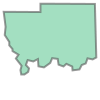

In [11]:
next(regions_reader.geometries())

In [12]:
# region_names = [record.attributes['NAME'] for record in regions_reader.records()]
# region_state = [record.attributes['STATE_NAME'] for record in regions_reader.records()]
# region_id = [record.attributes['OBJECTID'] for record in regions_reader.records()]
# region_fips = [record.attributes['FIPS'] for record in reguins_reader.records()]
# county_fips = [record.attributes['CNTY_FIPS'] for record in regions_reader.records()]
# state_fips = [record.attributes['STATE_FIPS'] for record in regions_reader.records()]

In [13]:
region_ids = [record.attributes['OBJECTID'] for record in regions_reader.records()]

In [14]:
print(region_ids[0], region_ids[-1])

1 3142


In [15]:
def get_region_record(target, shapefile=regions_reader, attribute='OBJECTID'):
    '''
    Get the geometries for the specified location.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = 'Could not find region with name "{}".'
        raise ValueError(emsg.format(target))
    return result

In [16]:
from random import randint
def rand_id(ids=region_ids): 
    return randint(ids[0], ids[-1])

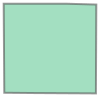

In [17]:
get_region_record(rand_id()).geometry

## Work out which files have been written, and which still have to be

In [18]:
csvs = glob.glob('/data/misc/covid-19/us_data_precip/*.csv')
len(csvs)

3

In [ ]:
df = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
df

In [ ]:
written = list(df['region'].unique().compute())
written

In [ ]:
len(written)

In [ ]:
unwritten = list(set(region_names).difference(set(written)))
len(unwritten)

In [ ]:
unwritten

In [ ]:
len(unwritten)+len(written)

## Create a pipeline

In [19]:
def parse_data_name(cube):
    name = cube.name()
    method = cube.cell_methods[1].method.replace('imum', '')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        units = 'W/m2'
    
    return f'{name}_{method} ({units})'

In [20]:
col0 = ['objectid', 'fips', 'county_name', 'state_name', 'date']
col1 = [parse_data_name(cube) for cube in us_cubes]

In [21]:
COL_ORDER = tuple(col0 + sorted([c for c in col1 if c not in col0]))
COL_ORDER

('objectid',
 'fips',
 'county_name',
 'state_name',
 'date',
 'precipitation_flux_max (kg m-2 s-1)',
 'precipitation_flux_mean (kg m-2 s-1)')

In [22]:
def extract(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
#     cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    return cut_cubes

In [23]:
def extract_collapse_df(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
    cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    time = cubes_col[0].coord('time')
    length = len(time.points)
    data = {'objectid': [location]*length,
            'fips': [region.attributes['FIPS']]*length,
            'county_name': [region.attributes['NAME']]*length,
            'state_name': [region.attributes['STATE_NAME']]*length,
            'date': [cell.point.date() for cell in time.cells()]}
    data.update({parse_data_name(cube): cube.data for cube in cubes_col})
    
    df = pd.DataFrame(data, columns=COL_ORDER)

    return df

899
0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 5; longitude: 5)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 5; longitude: 5)


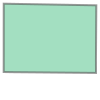

In [24]:
id_ = rand_id()
print(id_)
print(extract(id_, us_cubes, attribute='OBJECTID'))
display(get_region_record(id_, attribute='OBJECTID').geometry)

In [25]:
%%time
df_ex = extract_collapse_df(id_)
df_ex

CPU times: user 3.18 s, sys: 2.89 s, total: 6.08 s
Wall time: 4.13 s


,objectid,fips,county_name,state_name,date,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,899,20021,Cherokee,Kansas,2020-01-01,0.000000,0.000000e+00
1,899,20021,Cherokee,Kansas,2020-01-02,0.000000,0.000000e+00
2,899,20021,Cherokee,Kansas,2020-01-03,0.000002,7.629394e-08
3,899,20021,Cherokee,Kansas,2020-01-04,0.000000,0.000000e+00
4,899,20021,Cherokee,Kansas,2020-01-05,0.000000,0.000000e+00
...,...,...,...,...,...,...,...
86,899,20021,Cherokee,Kansas,2020-03-27,0.000033,1.977285e-06
87,899,20021,Cherokee,Kansas,2020-03-28,0.001091,7.574081e-05
88,899,20021,Cherokee,Kansas,2020-03-29,0.000000,0.000000e+00
89,899,20021,Cherokee,Kansas,2020-03-30,0.000133,6.167094e-06


## Save dataframe to csv for each location

In [89]:
print(us_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)


In [26]:
unwritten = region_ids
len(csvs)

3

In [ ]:
%%time
dfs = []
start = len(csvs)
stop = len(region_ids)
for location in unwritten[start:]:
    try:
        df = extract_collapse_df(location)
#         dfs.append(df)
        fname = df['fips'][0]
        county = df['county_name'][0]
        state = df['state_name'][0]
        df.to_csv(f'/data/misc/covid-19/us_data_precip/us_{fname}_daily_precipdata_2020jan-mar.csv', index=False)
        print(f'  [{location}] {fname}, {county}, {state}: Success')
#         display(df.iloc[[0]])
    except Exception as e:
        print(f'x [{location}] {fname}, {county}, {state}: Error \n  x  {e}')

  [4] 01007, Bibb, Alabama: Success
  [5] 01009, Blount, Alabama: Success
  [6] 01011, Bullock, Alabama: Success
  [7] 01013, Butler, Alabama: Success
  [8] 01015, Calhoun, Alabama: Success
  [9] 01017, Chambers, Alabama: Success
  [10] 01019, Cherokee, Alabama: Success
  [11] 01021, Chilton, Alabama: Success
  [12] 01023, Choctaw, Alabama: Success
  [13] 01025, Clarke, Alabama: Success
  [14] 01027, Clay, Alabama: Success
  [15] 01029, Cleburne, Alabama: Success
  [16] 01031, Coffee, Alabama: Success
  [17] 01033, Colbert, Alabama: Success
  [18] 01035, Conecuh, Alabama: Success
  [19] 01037, Coosa, Alabama: Success
  [20] 01039, Covington, Alabama: Success
  [21] 01041, Crenshaw, Alabama: Success
  [22] 01043, Cullman, Alabama: Success
  [23] 01045, Dale, Alabama: Success
  [24] 01047, Dallas, Alabama: Success
  [25] 01049, DeKalb, Alabama: Success
  [26] 01051, Elmore, Alabama: Success
  [27] 01053, Escambia, Alabama: Success
  [28] 01055, Etowah, Alabama: Success
  [29] 01057, Faye

## Open all the written CSVs and concatinate into one big DataFrame

In [ ]:
%%time
Mdf = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
Mdf

In [ ]:
def df_hists(df):
    for col in df:
        plt.hist(df[col])
        plt.title(f'{col}')
        plt.show()

In [ ]:
Mdf[Mdf.columns[5:]]

In [ ]:
%%time
df_hists(Mdf[Mdf.columns[5:]])

In [ ]:
%%time
Mdf.to_csv(f'/data/misc/covid-19/us_data/us_daily_meteodata_2020jan-mar_v01.csv', index=False)

In [ ]:
%%time
mdf = pd.read_csv('/data/misc/covid-19/us_data/us_daily_meteodata_2020jan-mar_v01.csv')
df_hists(mdf[mdf.columns[5:]])

In [ ]:
[[Alexandria, Virginia],
[Chesapeake, Virginia],
[Danville, Virginia],
[Fairfax City, Virginia],
[Manassas, Virginia],
[Waynesboro, Virginia]]

In [ ]:
get_region_record('Waynesboro', attribute='NAME')